# INTRODUCTION

Previous studies have conducted a comprehensive Exploratory Data Analysis (EDA) and developed various models to forecast bike-sharing demand. These studies included the use of SARIMAX and hybrid models, as well as STL decomposition combined with machine learning models.

1. [ Exploratory Data Analysis (EDA)](https://www.kaggle.com/code/tarktunataalt/washington-dc-capital-bikeshare-eda)
1. [SARIMAX and Hybrid Models](https://www.kaggle.com/code/tarktunataalt/bike-sharing-demand-sarimax-hybrid-models)
1. [ STL and Hybrid Models](https://www.kaggle.com/code/tarktunataalt/bike-sharing-demand-stl-hybrid-models)

In this notebook, the focus is on implementing Long Short-Term Memory (LSTM) networks to improve forecasting accuracy. LSTM models are well-suited for time series data as they can capture long-term dependencies and patterns. Both plain LSTM models and hybrid models, where LSTM is applied to the residuals obtained from STL decomposition, will be explored.

The performance of these models will be compared with previous approaches to identify the best model for predicting bike-sharing demand.



In [1]:
# Load required libraries
libraries <- c(
  "psych",
  "dplyr",
  "magrittr",
  "ggplot2",
  "gridExtra",
  "grid",
  "patchwork",
  "lmtest",
  "zoo",
  "xgboost",
  "Metrics",
  "plotly",
  "knitr",
  "forecast",
  "randomForest",
  "gbm",
  "lightgbm",
  "keras",
  "caret",
  "dplyr",
  "nortsTest",
  "tseries",
  "urca",
  "reshape2",
  "catboost"
)

load_libraries <- function(libraries) {
  for (lib in libraries) {
    if (!require(lib, character.only = TRUE)) {
      suppressMessages(suppressWarnings(install.packages(lib, dependencies = TRUE)))
      suppressPackageStartupMessages(library(lib, character.only = TRUE))
    } else {
      suppressPackageStartupMessages(library(lib, character.only = TRUE))
    }
  }
}

load_libraries(libraries)

# Load and preprocess data
data <- read.csv("/kaggle/input/bike-sharing-dataset/day.csv", header = TRUE)
data %<>% select(-c("instant", "casual", "registered"))
data$date <- as.Date(data$dteday, format = "%Y-%m-%d")
data$dteday <- NULL


Loading required package: psych

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: magrittr

Loading required package: ggplot2


Attaching package: ‘ggplot2’


The following objects are masked from ‘package:psych’:

    %+%, alpha


Loading required package: gridExtra


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Loading required package: grid

Loading required package: patchwork

Loading required package: lmtest

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: xgboost


Attaching package: ‘xgboost’


The following object is masked from ‘package:dplyr’:

    slice


Loading required package: Metrics

Lo

In [2]:
# Create lag 1 feature
data$cnt_lag1 <- lag(data$cnt, 1)
data$cnt_lag1[is.na(data$cnt_lag1)] <- 0

# Create dummy variables
dummy_vars <- c("season", "mnth", "weekday", "weathersit")
data <- data %>% mutate(across(all_of(dummy_vars), as.factor))

# Label encoding for specific variables
data$yr <- as.numeric(data$yr)
data$holiday <- as.numeric(data$holiday)
data$workingday <- as.numeric(data$workingday)

# Convert dummy variables
dummies <- dummyVars(~., data = data[, dummy_vars])
dummy_data <- predict(dummies, newdata = data[, dummy_vars])
data <- cbind(data, dummy_data)
data <- data[, !names(data) %in% dummy_vars]

# Split data into training and testing sets
train_size <- floor(0.8 * nrow(data))
train_indices <- 1:train_size
test_indices <- (train_size + 1):nrow(data)

train_data <- data[train_indices, ]
test_data <- data[test_indices, ]

# Select features for LSTM
features <- colnames(data)[!colnames(data) %in% c("cnt", "date", "Time")]

x_train <- train_data[, features]
y_train <- train_data$cnt
x_test <- test_data[, features]
y_test <- test_data$cnt


In [3]:
# STL decomposition
train_ts <- ts(train_data$cnt, start = c(2011, 1), frequency = 30)
decomposed <- stl(train_ts, s.window = "periodic")
stl_trend <- decomposed$time.series[, "trend"]
stl_seasonal <- decomposed$time.series[, "seasonal"]
stl_residuals <- decomposed$time.series[, "remainder"]

# Forecast the trend and seasonal components for the test period
n_test <- length(test_data$cnt)
stl_forecast_trend <- rep(tail(stl_trend, 1), n_test)
season_length <- frequency(train_ts)
stl_seasonal_cycle <- rep(stl_seasonal[(length(stl_seasonal) - season_length + 1):length(stl_seasonal)], length.out = n_test)
stl_forecast_seasonal <- rep(stl_seasonal_cycle, length.out = n_test)

# Combine forecasted trend and seasonal components
stl_forecast <- stl_forecast_trend + stl_forecast_seasonal

# Prepare the residuals for LSTM
y_train_stl <- stl_residuals
y_test_stl <- test_data$cnt - stl_forecast


In [4]:
# Scale data function
scale_data <- function(train, test, feature_range = c(0, 1)) {
  scaler <- list()
  scaled_train <- train
  scaled_test <- test
  for (feature in features) {
    x <- train[, feature]
    fr_min <- feature_range[1]
    fr_max <- feature_range[2]
    std_train <- (x - min(x)) / (max(x) - min(x))
    std_test <- (test[, feature] - min(x)) / (max(x) - min(x))
    scaled_train[, feature] <- std_train * (fr_max - fr_min) + fr_min
    scaled_test[, feature] <- std_test * (fr_max - fr_min) + fr_min
    scaler[[feature]] <- list(min = min(x), max = max(x))
  }
  return(list(scaled_train = scaled_train,
              scaled_test = scaled_test,
              scaler = scaler))
}
Scaled <- scale_data(x_train, x_test, c(-1, 1))
x_train <- as.matrix(Scaled$scaled_train)
x_test <- as.matrix(Scaled$scaled_test)

# Scale y_train and y_test for both plain LSTM and STL + LSTM
y_scaler <- list(min = min(y_train), max = max(y_train))
y_train_scaled <- (y_train - y_scaler$min) / (y_scaler$max - y_scaler$min) * 2 - 1
y_test_scaled <- (y_test - y_scaler$min) / (y_scaler$max - y_scaler$min) * 2 - 1

# Scale y_train_stl and y_test_stl for STL + LSTM
y_scaler_stl <- list(min = min(y_train_stl), max = max(y_train_stl))
y_train_stl_scaled <- (y_train_stl - y_scaler_stl$min) / (y_scaler_stl$max - y_scaler_stl$min) * 2 - 1
y_test_stl_scaled <- (y_test_stl - y_scaler_stl$min) / (y_scaler_stl$max - y_scaler_stl$min) * 2 - 1

# Convert data to 3D tensor format
dim(x_train) <- c(nrow(x_train), ncol(x_train), 1)
dim(x_test) <- c(nrow(x_test), ncol(x_test), 1)


In [5]:
# Define and compile the model
batch_size <- 1
units <- 50

model <- keras_model_sequential()

model %>%
  layer_lstm(units, batch_input_shape = c(batch_size, ncol(x_train), 1), stateful = TRUE, return_sequences = TRUE) %>%
  layer_dropout(rate = 0.2) %>%
  layer_lstm(units, stateful = TRUE) %>%
  layer_dropout(rate = 0.2) %>%
  layer_dense(units = 1)

model %>% compile(
  loss = 'mse',
  optimizer = optimizer_adam(learning_rate = 0.002),
  metrics = c("mae")
)
summary(model)

# Train the model for plain LSTM
Epochs <- 50
history <- model %>% fit(x_train, y_train_scaled, epochs = Epochs, batch_size = batch_size, verbose = 1, shuffle = FALSE)
model %>% reset_states()

# Train the model for STL + LSTM
history_stl <- model %>% fit(x_train, y_train_stl_scaled, epochs = Epochs, batch_size = batch_size, verbose = 1, shuffle = FALSE)
model %>% reset_states()


Model: "sequential"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 lstm_1 (LSTM)                      (1, 34, 50)                     10400       
 dropout_1 (Dropout)                (1, 34, 50)                     0           
 lstm (LSTM)                        (1, 50)                         20200       
 dropout (Dropout)                  (1, 50)                         0           
 dense (Dense)                      (1, 1)                          51          
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
________________________________________________________________________________


In [6]:
# Function to invert scaling
invert_scaling <- function(scaled, scaler, feature_range = c(-1, 1)) {
  min <- scaler$min
  max <- scaler$max
  t <- length(scaled)
  mins <- feature_range[1]
  maxs <- feature_range[2]
  inverted_dfs <- numeric(t)
  
  for(i in 1:t) {
    X <- (scaled[i] - mins) / (maxs - mins)
    rawValues <- X * (max - min) + min
    inverted_dfs[i] <- rawValues
  }
  return(inverted_dfs)
}

# Predictions for plain LSTM
predictions_lstm <- numeric(nrow(x_test))
for (i in 1:nrow(x_test)) {
  X <- array(x_test[i, , ], dim = c(1, ncol(x_test), 1))
  yhat <- model %>% predict(X, batch_size = batch_size)
  
  # Convert the predicted value back to original scale
  yhat <- invert_scaling(yhat, y_scaler, c(-1, 1))
  predictions_lstm[i] <- yhat
}

# Predictions for STL + LSTM
predictions_stl_lstm <- numeric(nrow(x_test))
for (i in 1:nrow(x_test)) {
  X <- array(x_test[i, , ], dim = c(1, ncol(x_test), 1))
  yhat <- model %>% predict(X, batch_size = batch_size)
  
  # Convert the predicted value back to original scale
  yhat <- invert_scaling(yhat, y_scaler_stl, c(-1, 1))
  predictions_stl_lstm[i] <- yhat
}


[1] "Root Mean Squared Error (RMSE) for LSTM: 1863.49397680897"
[1] "Root Mean Squared Error (RMSE) for STL + LSTM: 2043.19291756042"


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


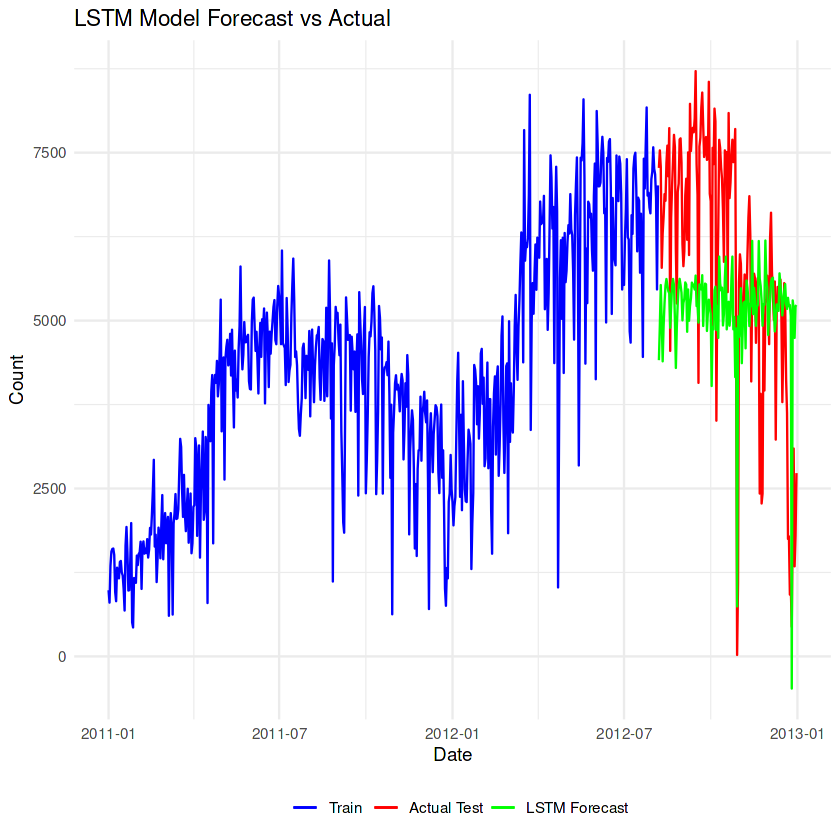

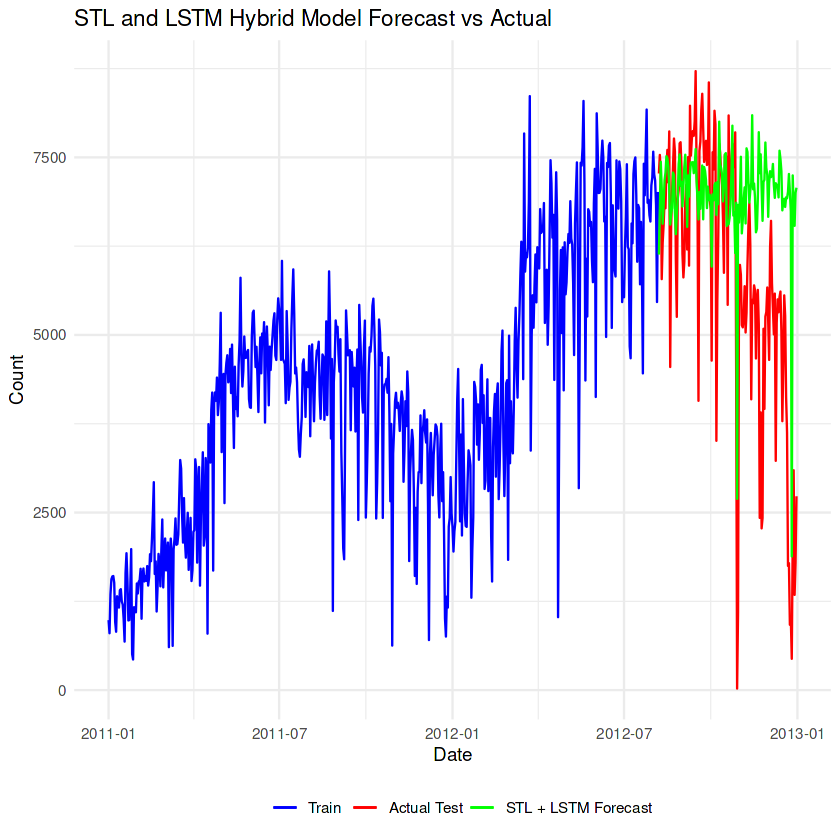

In [7]:
# Combine STL forecast and LSTM residuals for STL + LSTM model
final_forecast <- stl_forecast + predictions_stl_lstm

# Visualize the predictions for plain LSTM
test_data$LSTM_Predictions <- predictions_lstm

# Visualize the predictions for STL + LSTM
test_data$STL_LSTM_Predictions <- final_forecast

# Calculate RMSE using Metrics library for plain LSTM
lstm_rmse_value <- rmse(y_test, predictions_lstm)
print(paste("Root Mean Squared Error (RMSE) for LSTM:", lstm_rmse_value))

# Calculate RMSE using Metrics library for STL + LSTM
stl_lstm_rmse_value <- rmse(test_data$cnt, final_forecast)
print(paste("Root Mean Squared Error (RMSE) for STL + LSTM:", stl_lstm_rmse_value))

# Plot the predictions for plain LSTM
train_df <- data.frame(date = train_data$date, cnt = train_data$cnt, type = "Train")
test_df <- data.frame(date = test_data$date, cnt = test_data$cnt, type = "Test")
lstm_forecast_df <- data.frame(date = test_data$date, cnt = predictions_lstm, type = "LSTM Forecast")

ggplot() +
  geom_line(data = train_df, aes(x = date, y = cnt, color = 'Train'), size = 0.5) +
  geom_line(data = test_df, aes(x = date, y = cnt, color = 'Actual Test'), size = 0.5) +
  geom_line(data = lstm_forecast_df, aes(x = date, y = cnt, color = 'LSTM Forecast'), size = 0.5) +
  labs(title = 'LSTM Model Forecast vs Actual',
       x = 'Date',
       y = 'Count') +
  scale_color_manual(values = c('Train' = 'blue', 'Actual Test' = 'red', 'LSTM Forecast' = 'green'),
                     breaks = c('Train', 'Actual Test', 'LSTM Forecast')) +  
  theme_minimal() +
  theme(legend.position = "bottom") +
  guides(color = guide_legend(title = NULL))

# Plot the predictions for STL + LSTM
stl_lstm_forecast_df <- data.frame(date = test_data$date, cnt = final_forecast, type = "STL + LSTM Forecast")

ggplot() +
  geom_line(data = train_df, aes(x = date, y = cnt, color = 'Train'), size = 0.5) +
  geom_line(data = test_df, aes(x = date, y = cnt, color = 'Actual Test'), size = 0.5) +
  geom_line(data = stl_lstm_forecast_df, aes(x = date, y = cnt, color = 'STL + LSTM Forecast'), size = 0.5) +
  labs(title = 'STL and LSTM Hybrid Model Forecast vs Actual',
       x = 'Date',
       y = 'Count') +
  scale_color_manual(values = c('Train' = 'blue', 'Actual Test' = 'red', 'STL + LSTM Forecast' = 'green'),
                     breaks = c('Train', 'Actual Test', 'STL + LSTM Forecast')) +  
  theme_minimal() +
  theme(legend.position = "bottom") +
  guides(color = guide_legend(title = NULL))


When comparing the two models, it is observed that the LSTM model (RMSE: 1849.13) has a lower error rate. However, despite the STL + LSTM model (RMSE: 2042.22) having a higher error rate, it is noted for producing more reliable short-term forecasts. Therefore, for short-term predictions, the STL + LSTM model might be preferred. The short-term reliability of the STL + LSTM model can be attributed to better capturing seasonal components and more accurately predicting short-term fluctuations.